# **Project: Solar Cycle**

**Course:** Optimisation and High performance Computing (OHPC-HS25-AD23)  
**Team Members:** Cieplinski Nicole, Plos Penelope, Yeji Huber
**Date:** 16.01.2026

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path
import glob

## Simulated Annealing (SA) function

### SA function for hyper-parameter tuning

In [2]:
def sa_tune(x0, T0, sigma, f, n_iter = 2e5, thinning = 1):

    x = x0.copy()           # initial x
    T = T0                  # initial temperature
    n_params = x0.shape[0]  # number of parameters to optimized

    # Means and covariance matrix for the jump distribution -> multivariate normal with mean 0 and standard deviation sigma 
    means = np.full(n_params, 0)
    cov_matrix = np.diag(np.full(n_params, sigma))

    # Calculate size of the output array after thinning
    # (thinning -> save states at regular intervals instead of every iteration) 
    # Thinning is by defaut 1, and size_out = n_iter
    size_out = int((n_iter + thinning -1)//thinning)    # equivalent to ceiling (n_iter/thinning)
    v = np.zeros((size_out, n_params))
    # Store the initial parameter array
    v[0,:] = x

    iter_counter = 0
    iter_counter_thin = 0
    print("Initial loss:", f(x))
    #start main loop
    while iter_counter < n_iter:
        iter_counter += 1;
        x_old = x;
        x_proposal = x_old + np.random.multivariate_normal(means, cov_matrix)
        DeltaE = f(x_proposal) - f(x_old)
        #Metropolis accept/reject step 
        if np.exp(-np.clip(DeltaE, -100, 100)) >= np.random.rand():
            x = x_proposal
        else:
            x = x_old
        
        # Update temperature according to schedule
        T = T0 * (1 - iter_counter/n_iter)
        # Keep track of accepted state
        if iter_counter%1 == 0:
            print("Iteration", iter_counter, " - Temperature:", T, "Loss", f(x))
        if iter_counter%thinning == 0:
            v[iter_counter_thin,:] = x
            iter_counter_thin += 1
    
    return v
    

### SA function for final optimization

In [3]:
def sa_optimize(x0, T0, sigma, f, n_iter = 2.5e5, burn_in = 2e5):

    x = x0.copy()           # initial x
    T = T0                  # initial temperature
    n_params = x0.shape[0]  # number of parameters to optimized
    
    # means and covariance matrix for the jump distribution -> multivariate normal
    means = np.full(n_params, 0)
    cov_matrix = np.diag(np.full(n_params, sigma))

    # Size of the output array after burn_in
    size_out = int(n_iter - burn_in)
    v = np.zeros((size_out, n_params))
    
    iter_counter = 0
    print("Initial loss:", f(x))
    # Start main loop
    while iter_counter < n_iter:
        iter_counter += 1;
        x_old = x;
        x_proposal = x_old + np.random.multivariate_normal(means, cov_matrix)
        DeltaE = f(x_proposal) - f(x_old)
        # Metropolis accept/reject step
        if np.exp(-np.clip(DeltaE/T, -100,100)) >= np.random.rand():
            x = x_proposal
        else:
            x = x_old
        # Update temperature according to schedule
        T = T0*(1-iter_counter/n_iter)
        # keep track of the algorithm state
        if iter_counter%10 == 0:
            print("Iteration ", iter_counter, " - Temperature:", T, " - Loss:", f(x))
        if iter_counter > burn_in:
            v[iter_counter-int(burn_in)-1, :] = x

    return v 

## Load data

In [4]:
data = np.loadtxt('data_Team9.csv', delimiter=',', skiprows=1) 

In [5]:
data.shape

(39220, 2)

In [6]:
data

array([[1878.15199877,   13.65877439],
       [1878.15477652,   13.22461169],
       [1878.15755428,   14.05492822],
       ...,
       [1987.08717135,    8.53057405],
       [1987.08994911,    3.49094437],
       [1987.09272686,    0.        ]])

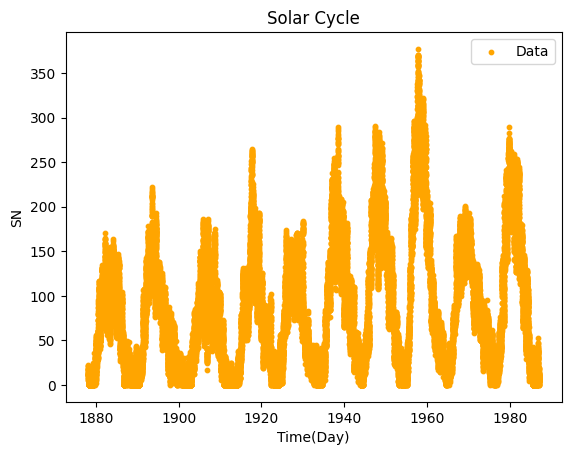

In [7]:
#Plot data for visualization
plt.figure()
plt.scatter(data[:,0], data[:,1], color="Orange", s=10, label= "Data")
plt.xlabel("Time(Day)")
plt.ylabel("SN")
plt.title("Solar Cycle")
plt.legend()
plt.show()

In [7]:
time_points = data[:, 0]
n_data = time_points.shape[0]
data_points = data[:, 1]

print(time_points)
print(n_data)
print(data_points)

[1878.15199877 1878.15477652 1878.15755428 ... 1987.08717135 1987.08994911
 1987.09272686]
39220
[13.65877439 13.22461169 14.05492822 ...  8.53057405  3.49094437
  0.        ]


## Initial conditions

### parameters              
 Phase 1: T01, Ts1, Td1     
 Phase 2: T02, Ts2, Td2         
...     
 Phase 10: T010, Ts10, Td10   

### Ts and Td

In [8]:
# x0 = np.array([Ts1, Td1, Ts2, Td2, ...])
# here we use initial conditions given in the final project intro 

x0 = np.array([0.3, 5, 0.3, 5, 0.3, 5, 0.3, 5, 0.3, 5, 0.3, 5, 0.3, 5, 0.3, 5, 0.3, 5, 0.3, 5])

In [9]:
# The different parameters can be extracted as follows:
Ts = x0[::2]
Td = x0[1::2]

print(Ts)
print(Td)

# Number of phases
num_phases = len(Ts)
num_phases

[0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3]
[5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]


10

### T0

In [10]:
# make T0 array with initial conditions reported in Hathaway 2015
T0array = (1878.916666666666667, 1890.166666666666667, 1902.000000000000000, 1913.500000000000000, 1923.583333333333333, 1933.666666666666667, 1944.083333333333333, 1954.250000000000000, 1964.750000000000000, 1976.166666666666667, 1986.666666666666667)
# Create list of time intervals for each phase
intervals = [(float(T0array[ix]),float(T0array[ix+1])) for ix in range(num_phases)]

print(intervals)

[(1878.9166666666667, 1890.1666666666667), (1890.1666666666667, 1902.0), (1902.0, 1913.5), (1913.5, 1923.5833333333333), (1923.5833333333333, 1933.6666666666667), (1933.6666666666667, 1944.0833333333333), (1944.0833333333333, 1954.25), (1954.25, 1964.75), (1964.75, 1976.1666666666667), (1976.1666666666667, 1986.6666666666667)]


In [11]:
# We will use a loop to process all phases
for ix, (a, b) in enumerate(intervals):
    print("Processing phase", ix+1, "with interval (", a, ",", b, ")")

Processing phase 1 with interval ( 1878.9166666666667 , 1890.1666666666667 )
Processing phase 2 with interval ( 1890.1666666666667 , 1902.0 )
Processing phase 3 with interval ( 1902.0 , 1913.5 )
Processing phase 4 with interval ( 1913.5 , 1923.5833333333333 )
Processing phase 5 with interval ( 1923.5833333333333 , 1933.6666666666667 )
Processing phase 6 with interval ( 1933.6666666666667 , 1944.0833333333333 )
Processing phase 7 with interval ( 1944.0833333333333 , 1954.25 )
Processing phase 8 with interval ( 1954.25 , 1964.75 )
Processing phase 9 with interval ( 1964.75 , 1976.1666666666667 )
Processing phase 10 with interval ( 1976.1666666666667 , 1986.6666666666667 )


## Model and Loss Function

### Model

In [12]:
# Model for multiple phases:
def model(t, x):
    Ts = x[::2]
    Td = x[1::2]
    num_phases = len(T0array)
    intervals = [(T0array[ix],T0array[ix+1]) for ix in range(num_phases-1)]
    #Ensure t is treated as an array for consistency
    t = np.atleast_1d(t)
    model_output = np.zeros_like(t)
    for ix, (a,b) in enumerate(intervals):
        # Create mask for current phase
        mask = (a <= t) & (t < b)
        # Apply model for current phase
        model_output[mask] = ((t[mask] - T0array[ix])/Ts[ix])**2 * np.exp(-((t[mask] - T0array[ix])/Td[ix])**2)
    if model_output.size == 1:
        return model_output.item()
    else:
        return model_output


### Loss function

In [13]:
# Loss function
def mse(x):
    return np.mean(np.square(data_points - model(time_points, x)))

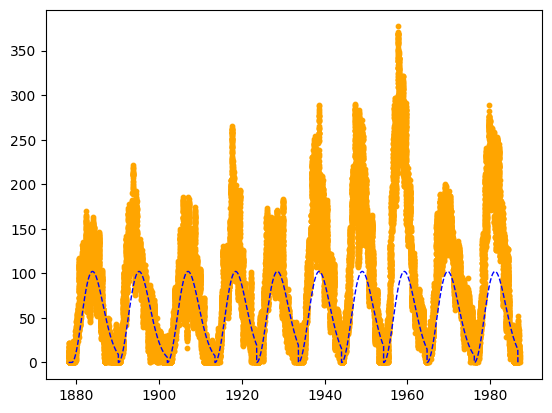

np.float64(3228.920368766796)

In [16]:
# Visualisation
plt.figure()
plt.scatter(time_points, data_points, color='orange', s=10)
plt.plot(time_points, model(time_points, x0), color='blue', linestyle='--', linewidth=1)
plt.show(block=False)

# Initial mse:
mse(x0)

## Hyper-parameters tuning

### Quick exploration (showing our process)
Before running a full sweep, we tested a few sigma and T0 values to find a reasonable range (avoiding unstable jumps and ensuring the loss decreases).
We log the final MSE for each trial.
We plot the loss curve for each trial and evaluate each trial with these plots.

In [33]:
trial_log = []  # list of dicts

def log_trial(T0, sigma, final_x):
    trial_log.append({
        "T0": float(T0),
        "sigma": float(sigma),
        "final_mse": float(mse(final_x))
    })

#### Test to find the sigma range

Initial loss: 3228.920368766796
Iteration 1  - Temperature: 0.9999 Loss 3228.920368766796
Iteration 2  - Temperature: 0.9998 Loss 3228.920368766796
Iteration 3  - Temperature: 0.9997 Loss 3228.920368766796
Iteration 4  - Temperature: 0.9996 Loss 3228.920368766796
Iteration 5  - Temperature: 0.9995 Loss 3228.920368766796
Iteration 6  - Temperature: 0.9994 Loss 3228.920368766796
Iteration 7  - Temperature: 0.9993 Loss 3228.920368766796
Iteration 8  - Temperature: 0.9992 Loss 3228.920368766796
Iteration 9  - Temperature: 0.9991 Loss 3228.920368766796
Iteration 10  - Temperature: 0.999 Loss 3228.920368766796
Iteration 11  - Temperature: 0.9989 Loss 3228.920368766796
Iteration 12  - Temperature: 0.9988 Loss 3228.920368766796
Iteration 13  - Temperature: 0.9987 Loss 3228.920368766796
Iteration 14  - Temperature: 0.9986 Loss 3228.920368766796
Iteration 15  - Temperature: 0.9985 Loss 3228.920368766796
Iteration 16  - Temperature: 0.9984 Loss 3228.920368766796
Iteration 17  - Temperature: 0.998

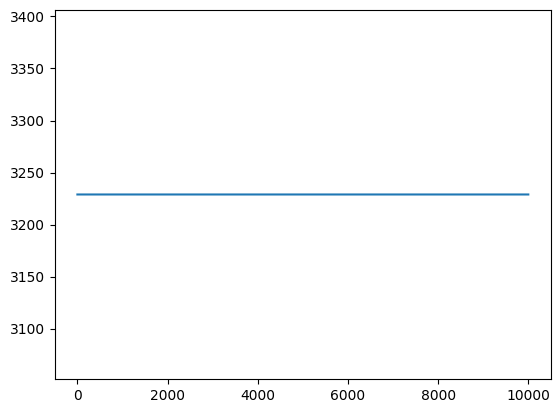

In [34]:
T0 = 1
sigma = 1
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])
log_trial(T0, sigma, outSA[-1])

Initial loss: 3228.920368766796
Iteration 1  - Temperature: 0.9999 Loss 3228.920368766796
Iteration 2  - Temperature: 0.9998 Loss 3228.920368766796
Iteration 3  - Temperature: 0.9997 Loss 3228.920368766796
Iteration 4  - Temperature: 0.9996 Loss 3228.920368766796
Iteration 5  - Temperature: 0.9995 Loss 3228.920368766796
Iteration 6  - Temperature: 0.9994 Loss 3228.920368766796
Iteration 7  - Temperature: 0.9993 Loss 3228.920368766796
Iteration 8  - Temperature: 0.9992 Loss 3228.920368766796
Iteration 9  - Temperature: 0.9991 Loss 3228.920368766796
Iteration 10  - Temperature: 0.999 Loss 3228.920368766796
Iteration 11  - Temperature: 0.9989 Loss 3228.920368766796
Iteration 12  - Temperature: 0.9988 Loss 3228.920368766796
Iteration 13  - Temperature: 0.9987 Loss 3228.920368766796
Iteration 14  - Temperature: 0.9986 Loss 3228.920368766796
Iteration 15  - Temperature: 0.9985 Loss 3228.920368766796
Iteration 16  - Temperature: 0.9984 Loss 3228.920368766796
Iteration 17  - Temperature: 0.998

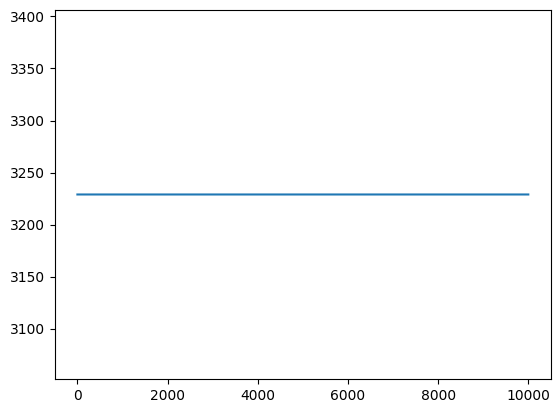

In [35]:
T0 = 1
sigma = 0.1
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])
log_trial(T0, sigma, outSA[-1])

Initial loss: 3228.920368766796
Iteration 1  - Temperature: 0.9999 Loss 3228.920368766796
Iteration 2  - Temperature: 0.9998 Loss 3228.920368766796
Iteration 3  - Temperature: 0.9997 Loss 3228.920368766796
Iteration 4  - Temperature: 0.9996 Loss 3228.920368766796
Iteration 5  - Temperature: 0.9995 Loss 3228.920368766796
Iteration 6  - Temperature: 0.9994 Loss 2723.1075409413857
Iteration 7  - Temperature: 0.9993 Loss 2723.1075409413857
Iteration 8  - Temperature: 0.9992 Loss 2723.1075409413857
Iteration 9  - Temperature: 0.9991 Loss 2723.1075409413857
Iteration 10  - Temperature: 0.999 Loss 2723.1075409413857
Iteration 11  - Temperature: 0.9989 Loss 2723.1075409413857
Iteration 12  - Temperature: 0.9988 Loss 2723.1075409413857
Iteration 13  - Temperature: 0.9987 Loss 2723.1075409413857
Iteration 14  - Temperature: 0.9986 Loss 2723.1075409413857
Iteration 15  - Temperature: 0.9985 Loss 2723.1075409413857
Iteration 16  - Temperature: 0.9984 Loss 2723.1075409413857
Iteration 17  - Tempera

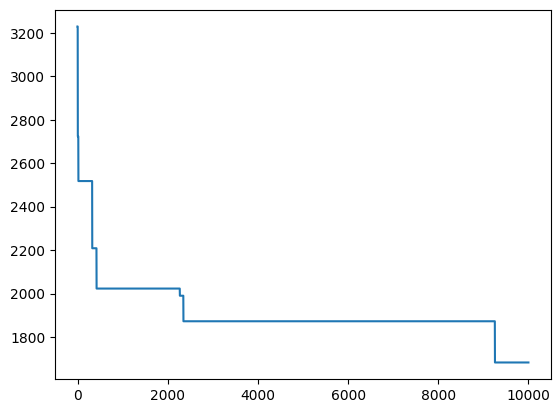

In [36]:
T0 = 1
sigma = 0.01
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])
log_trial(T0, sigma, outSA[-1])

Initial loss: 3228.920368766796
Iteration 1  - Temperature: 0.9999 Loss 3228.920368766796
Iteration 2  - Temperature: 0.9998 Loss 3228.920368766796
Iteration 3  - Temperature: 0.9997 Loss 3228.920368766796
Iteration 4  - Temperature: 0.9996 Loss 3228.920368766796
Iteration 5  - Temperature: 0.9995 Loss 3228.920368766796
Iteration 6  - Temperature: 0.9994 Loss 3228.920368766796
Iteration 7  - Temperature: 0.9993 Loss 3228.920368766796
Iteration 8  - Temperature: 0.9992 Loss 3228.920368766796
Iteration 9  - Temperature: 0.9991 Loss 2467.8122945580453
Iteration 10  - Temperature: 0.999 Loss 2467.8122945580453
Iteration 11  - Temperature: 0.9989 Loss 2467.8122945580453
Iteration 12  - Temperature: 0.9988 Loss 2467.8122945580453
Iteration 13  - Temperature: 0.9987 Loss 2467.8122945580453
Iteration 14  - Temperature: 0.9986 Loss 2067.8487357948193
Iteration 15  - Temperature: 0.9985 Loss 2067.8487357948193
Iteration 16  - Temperature: 0.9984 Loss 2067.8487357948193
Iteration 17  - Temperatur

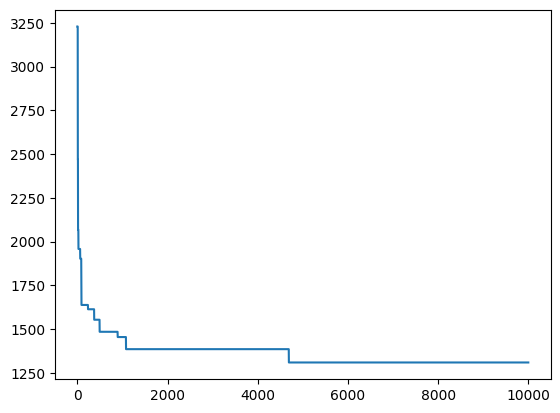

In [37]:
T0 = 1
sigma = 0.001
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])
log_trial(T0, sigma, outSA[-1])

Initial loss: 3228.920368766796
Iteration 1  - Temperature: 0.9999 Loss 3033.7901164737864
Iteration 2  - Temperature: 0.9998 Loss 2986.19569298866
Iteration 3  - Temperature: 0.9997 Loss 2986.19569298866
Iteration 4  - Temperature: 0.9996 Loss 2888.2308116350923
Iteration 5  - Temperature: 0.9995 Loss 2888.2308116350923
Iteration 6  - Temperature: 0.9994 Loss 2888.2308116350923
Iteration 7  - Temperature: 0.9993 Loss 2852.4247322140754
Iteration 8  - Temperature: 0.9992 Loss 2785.261150908978
Iteration 9  - Temperature: 0.9991 Loss 2724.888990685905
Iteration 10  - Temperature: 0.999 Loss 2724.888990685905
Iteration 11  - Temperature: 0.9989 Loss 2724.888990685905
Iteration 12  - Temperature: 0.9988 Loss 2603.4966444243387
Iteration 13  - Temperature: 0.9987 Loss 2421.858532116826
Iteration 14  - Temperature: 0.9986 Loss 2421.858532116826
Iteration 15  - Temperature: 0.9985 Loss 2421.858532116826
Iteration 16  - Temperature: 0.9984 Loss 2421.858532116826
Iteration 17  - Temperature: 0

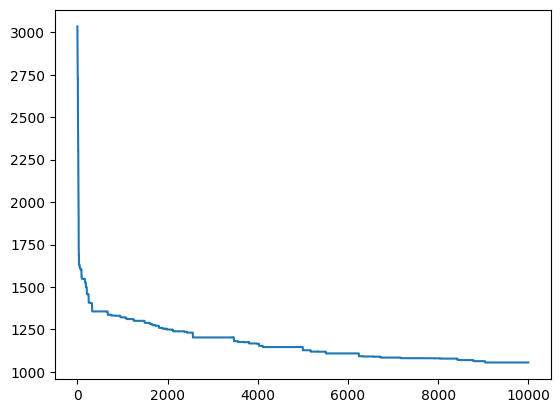

In [38]:
T0 = 1
sigma = 0.0001
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])
log_trial(T0, sigma, outSA[-1])

Initial loss: 3228.920368766796
Iteration 1  - Temperature: 0.9999 Loss 3228.920368766796
Iteration 2  - Temperature: 0.9998 Loss 3228.920368766796
Iteration 3  - Temperature: 0.9997 Loss 3228.271644144078
Iteration 4  - Temperature: 0.9996 Loss 3228.271644144078
Iteration 5  - Temperature: 0.9995 Loss 3206.884873841405
Iteration 6  - Temperature: 0.9994 Loss 3206.884873841405
Iteration 7  - Temperature: 0.9993 Loss 3178.5751776840207
Iteration 8  - Temperature: 0.9992 Loss 3178.5751776840207
Iteration 9  - Temperature: 0.9991 Loss 3171.4304847357203
Iteration 10  - Temperature: 0.999 Loss 3171.4304847357203
Iteration 11  - Temperature: 0.9989 Loss 3167.444578939023
Iteration 12  - Temperature: 0.9988 Loss 3167.444578939023
Iteration 13  - Temperature: 0.9987 Loss 3144.1426653986705
Iteration 14  - Temperature: 0.9986 Loss 3144.1426653986705
Iteration 15  - Temperature: 0.9985 Loss 3126.8360086953635
Iteration 16  - Temperature: 0.9984 Loss 3104.579706583532
Iteration 17  - Temperature

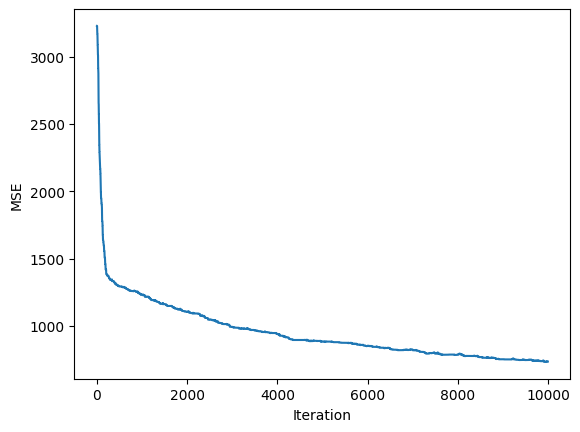

np.float64(735.182724192606)

In [39]:
T0 = 1
sigma = 0.00001
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, axis=1, arr=outSA)
plt.plot(mse_curve)
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.show(block=False)

log_trial(T0, sigma, outSA[-1])
mse(outSA[-1])

In [40]:
df_trials = pd.DataFrame(trial_log).sort_values("final_mse").reset_index(drop=True)
df_trials.head(10)

T0    sigma    final_mse
0  1.0  0.00001   735.182724
1  1.0  0.00010  1055.537183
2  1.0  0.00100  1309.693453
3  1.0  0.01000  1682.719704
4  1.0  1.00000  3228.920369
5  1.0  0.10000  3228.920369

-> we can test sigma from 1e-4 to 1e-11

#### Test to find the sigma range

Initial loss: 3228.920368766796
Iteration 1  - Temperature: 0.09999000000000001 Loss 3185.682494687317
Iteration 2  - Temperature: 0.09998000000000001 Loss 3175.6745282768547
Iteration 3  - Temperature: 0.09997 Loss 3175.6745282768547
Iteration 4  - Temperature: 0.09996000000000001 Loss 3175.6745282768547
Iteration 5  - Temperature: 0.09995000000000001 Loss 3175.6745282768547
Iteration 6  - Temperature: 0.09994 Loss 3148.366906134414
Iteration 7  - Temperature: 0.09993 Loss 3148.366906134414
Iteration 8  - Temperature: 0.09992000000000001 Loss 3148.366906134414
Iteration 9  - Temperature: 0.09991 Loss 3148.366906134414
Iteration 10  - Temperature: 0.0999 Loss 3148.366906134414
Iteration 11  - Temperature: 0.09989 Loss 3148.366906134414
Iteration 12  - Temperature: 0.09988000000000001 Loss 3148.366906134414
Iteration 13  - Temperature: 0.09987000000000001 Loss 3148.366906134414
Iteration 14  - Temperature: 0.09986 Loss 3148.366906134414
Iteration 15  - Temperature: 0.09985000000000001 L

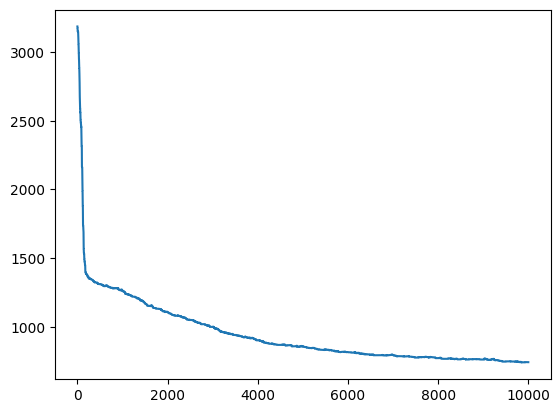

In [41]:
T0 = 0.1
sigma = 0.00001
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])
log_trial(T0, sigma, outSA[-1])

Initial loss: 3228.920368766796
Iteration 1  - Temperature: 4.9995 Loss 3228.920368766796
Iteration 2  - Temperature: 4.9990000000000006 Loss 3228.920368766796
Iteration 3  - Temperature: 4.9985 Loss 3228.920368766796
Iteration 4  - Temperature: 4.998 Loss 3201.761444833674
Iteration 5  - Temperature: 4.9975000000000005 Loss 3194.5038133080616
Iteration 6  - Temperature: 4.997 Loss 3194.5038133080616
Iteration 7  - Temperature: 4.9965 Loss 3193.473192536521
Iteration 8  - Temperature: 4.9959999999999996 Loss 3193.473192536521
Iteration 9  - Temperature: 4.9955 Loss 3140.3830013087504
Iteration 10  - Temperature: 4.995 Loss 3140.3830013087504
Iteration 11  - Temperature: 4.9945 Loss 3140.3830013087504
Iteration 12  - Temperature: 4.994 Loss 3119.057411467019
Iteration 13  - Temperature: 4.9935 Loss 3119.057411467019
Iteration 14  - Temperature: 4.993 Loss 3119.057411467019
Iteration 15  - Temperature: 4.992500000000001 Loss 3119.057411467019
Iteration 16  - Temperature: 4.992 Loss 3119.

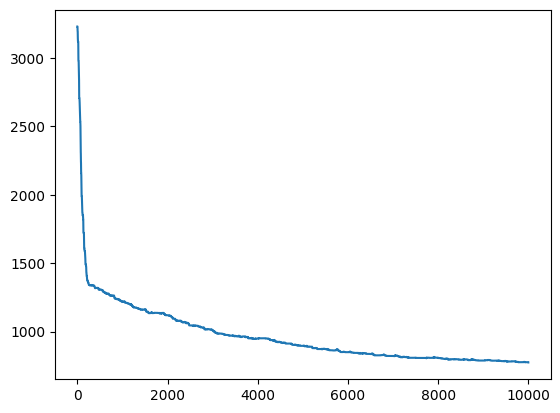

In [42]:
T0 = 5
sigma = 0.00001
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])
log_trial(T0, sigma, outSA[-1])

Initial loss: 3228.920368766796
Iteration 1  - Temperature: 9.999 Loss 3228.920368766796
Iteration 2  - Temperature: 9.998000000000001 Loss 3228.920368766796
Iteration 3  - Temperature: 9.997 Loss 3228.920368766796
Iteration 4  - Temperature: 9.996 Loss 3187.486854536011
Iteration 5  - Temperature: 9.995000000000001 Loss 3145.6778660271116
Iteration 6  - Temperature: 9.994 Loss 3129.984083749541
Iteration 7  - Temperature: 9.993 Loss 3129.984083749541
Iteration 8  - Temperature: 9.991999999999999 Loss 3106.488699253377
Iteration 9  - Temperature: 9.991 Loss 3077.9856694778773
Iteration 10  - Temperature: 9.99 Loss 3066.402185688517
Iteration 11  - Temperature: 9.989 Loss 2981.4274354075237
Iteration 12  - Temperature: 9.988 Loss 2936.7089761006428
Iteration 13  - Temperature: 9.987 Loss 2898.9272081219005
Iteration 14  - Temperature: 9.986 Loss 2842.8828535543516
Iteration 15  - Temperature: 9.985000000000001 Loss 2801.411862180363
Iteration 16  - Temperature: 9.984 Loss 2801.411862180

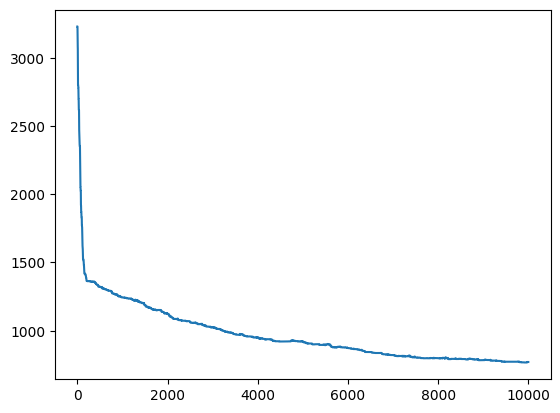

In [43]:
T0 = 10
sigma = 0.00001
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])
log_trial(T0, sigma, outSA[-1])

In [44]:
df_trials = pd.DataFrame(trial_log).sort_values("final_mse")
df_trials.head(3)

T0    sigma   final_mse
5   1.0  0.00001  735.182724
6   0.1  0.00001  743.788841
8  10.0  0.00001  770.828413

-> there is no big diffrence. so we will test T0 from 0.1 to 10

### Hyperparameter tuning on the cluster (8×8 = 64)
We plot the loss curve for each trial and evaluate each trial with these plots.  
With the visual check of the plots, we selected at first trial 6,14,22,30,38,54,62.   
After that we load JSON outputs from the Slurm job array with final mse value and pick the best (T0, sigma).

In [14]:
tuning_dir = Path("results_tuning")

# Load only selected trials: 6, 14, 22, 30, 38, 54, 62
selected_trials = [6, 14, 22, 30, 38, 54, 62]
tuning_files = [tuning_dir / f"tuning_{idx:02d}.json" for idx in selected_trials]

rows = []
for path in tuning_files:
    with path.open("r") as f:
        rows.append(json.load(f))

df_tune = pd.DataFrame(rows).sort_values("final_mse").reset_index(drop=True)
df_tune[["idx", "T0", "sigma", "final_mse", "wall_time_sec"]]

idx    T0    sigma   final_mse  wall_time_sec
0   62  10.0  0.00001  596.352615     635.581329
1   54   8.0  0.00001  598.270705     616.808225
2   38   2.0  0.00001  599.150110     633.277182
3   22   0.5  0.00001  599.584147     621.538963
4    6   0.1  0.00001  599.892973     633.347446
5   30   1.0  0.00001  601.469897     632.576727
6   14   0.2  0.00001  606.406542     636.206005

Best hyperparameters from 64-run sweep:
T0_opt = 10.0
sigma_opt = 9.999999999999999e-06
best MSE = 596.3526149165218


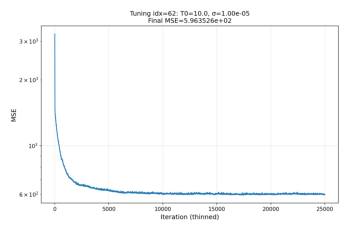

In [15]:
best = df_tune.iloc[0]
T0_opt = best["T0"]
sigma_opt = best["sigma"]
x_opt_from_sweep = np.array(best["final_x"], dtype=float)

print("Best hyperparameters from 64-run sweep:")
print("T0_opt =", T0_opt)
print("sigma_opt =", sigma_opt)
print("best MSE =", best["final_mse"])

# Also display the saved MSE curve PNG if available
png_path = Path("results_tuning") / f"mse_curve_{int(best['idx']):02d}.png"
if png_path.exists():
    img = plt.imread(png_path)
    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    plt.show(block=False)
else:
    print(f"PNG not found: {png_path}")

#### Visual check of the best tuned solution
We plot the best tuned model output against the data as a sanity check before final optimization.

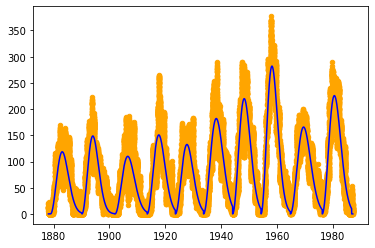

In [16]:
plt.figure()
plt.scatter(time_points, data_points, color='orange', s=20)
plt.plot(time_points, model(time_points, x_opt_from_sweep), color='blue')
plt.show(block=False)

## Calibration on the cluster (parallel chains + speedup)
Load calibration JSON files and extract the fitted parameters (center_of_mass). Plot wall time vs cores.

In [ ]:
calib_dir = Path("results_calibration")
calib_files = sorted(calib_dir.glob("calib_workers*_chains*.json"))

assert len(calib_files) > 0, "No calibration result files found in results_calibration/"

rows = []
for path in calib_files:
    with path.open("r") as f:
        rows.append(json.load(f))

df_calib = pd.DataFrame(rows).sort_values("n_workers").reset_index(drop=True)
df_calib[["n_workers", "wall_time_sec", "final_mse", "n_chains"]]

In [ ]:
plt.figure()
plt.plot(df_calib["n_workers"], df_calib["wall_time_sec"], marker="o")
plt.xlabel("Cores (cpus-per-task)")
plt.ylabel("Wall time (s)")
plt.show()

t1 = float(df_calib[df_calib["n_workers"]==1]["wall_time_sec"].iloc[0])
df_calib["speedup"] = t1 / df_calib["wall_time_sec"]

plt.figure()
plt.plot(df_calib["n_workers"], df_calib["speedup"], marker="o")
plt.xlabel("Cores (cpus-per-task)")
plt.ylabel("Speedup (T1/Tp)")
plt.show()

In [ ]:
row_final = df_calib.sort_values("n_workers").iloc[-1]  # or choose lowest MSE
center_of_mass = np.array(row_final["center_of_mass"], dtype=float)

print("Using calibration from", row_final["n_workers"], "cores")
print("Calibration MSE:", row_final["final_mse"])

### correlation between Ts and Td

In [ ]:
# Your model uses pairs: [Ts1, Td1, Ts2, Td2, ...]
ts = center_of_mass[0::2]
td = center_of_mass[1::2]

slope, intercept = np.polyfit(ts, td, 1)
td_fit = slope * ts + intercept

plt.figure()
plt.scatter(ts, td, s=20)
plt.plot(ts, td_fit, label=f'Fit: td = {slope:.4f} * ts + {intercept:.4f}')
plt.xlabel('Ts')
plt.ylabel('Td')
plt.legend()
plt.show(block=False)

slope, intercept

In [ ]:
plt.figure()
plt.scatter(time_points, data_points, s=10, label="Data")
plt.plot(time_points, model(time_points, center_of_mass), label="Final calibrated model")
plt.legend()
plt.show()

### R^2 coefficient

In [ ]:
residuals = td - td_fit

ss_total = np.sum((td - np.mean(td)) ** 2)
ss_residual = np.sum(residuals ** 2)

r_squared = 1 - (ss_residual / ss_total)
print(f"R² = {r_squared:.3f}")

### comparison to literature 

In [ ]:
# If the literature reports a slope per year vs per day (or vice versa),
# you may need a rough rescaling depending on your time resolution.
# Teacher example divides by 365 for ~daily resolution.

slope_per_year_est = slope / 365.0
print("slope =", slope)
print("slope/365 =", slope_per_year_est)

# Add your literature target value here once you have it:
# print("Literature slope ~", 0.02)  # example placeholder

In [ ]:
pred = model(time_points, center_of_mass)
res = data_points - pred

plt.figure()
plt.scatter(time_points, res, s=10)
plt.axhline(0)
plt.xlabel("Time")
plt.ylabel("Residual (data - model)")
plt.show(block=False)

print("Final MSE =", np.mean(res**2))